In [2]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import geopy as gpy
from IPython.display import Image
from geopy.geocoders import Nominatim
import regex as re
from shapely import wkt
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import seaborn as sns
%matplotlib inline
ox.__version__

'1.2.2'

## Setting up parameters for calculating POI data

In [3]:
bad_amenities = ['driving_school', 'car_rental', 'car_wash', \
    'vehicle_inspection', 'fuel', 'grit_bin', \
    'motorcycle_parking', 'parking', 'parking_entrance', \
    'parking_space', 'taxi']


tab_buildings = pd.read_html('https://wiki.openstreetmap.org/wiki/Key:building', match='Value')
tab_amenities = pd.read_html('https://wiki.openstreetmap.org/wiki/Key:amenity', match='Value')

building_types = tab_buildings[0]
amenity_types = tab_amenities[0]

building_types.columns = building_types.columns.droplevel(1)
amenity_types.columns = amenity_types.columns.droplevel(1)
amenity_types = amenity_types[(amenity_types['Key'] == 'amenity') & (~amenity_types['Value'].isin(bad_amenities))]
desired_amenities = list(amenity_types['Value'])



categories_df = building_types[building_types['Key'] != 'building']
categories = ['Accomodation']
categories.extend(categories_df['Key'])
categories_ind = categories_df.index
categories_ind, categories
desired_slices = [np.arange(18,25), np.arange(26, 37), np.arange(38, 53), np.arange(69, 72)]
desired_inds = np.concatenate(desired_slices)
desired_types = list(building_types.loc[desired_inds]['Value'])

# Example of bike lane vs cycleway only lane

In [ ]:


import osmnx as ox
useful_tags = ox.settings.useful_tags_way + ['cycleway']
ox.config(use_cache=True, log_console=True, useful_tags_way=useful_tags)
coords = (36.904385	,-121.770475)
G = ox.graph_from_point(coords, dist=2000, network_type="bike", simplify=False)
non_cycleways = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) if not ('cycleway' in d or d['highway']=='cycleway')]
G_trunc = G
G_trunc.remove_edges_from(non_cycleways)
G_trunc = ox.utils_graph.remove_isolated_nodes(G_trunc)
G_trunc = ox.simplify_graph(G_trunc)
# G_comb = nx.compose(G, G_trunc)
# G = ox.utils_graph.remove_isolated_nodes(G)
# G = ox.simplify_graph(G)

fig, ax = ox.plot_graph(G, node_size=5)
fig, ax = ox.plot_graph(G_trunc, node_color='r')


## Getting stats of BIke friendly and non bike friendly cities

We select cities from articles and their research regarding what they define to be bike friendly or not bike friendly

In [68]:
bike_friendly_cities = {'Portland, Oregon': (45.523064, -122.676483),
                    'SF, CA': (37.7749, -122.4194),
                    'MN, MN': (44.9778, -93.2650),
                    'SJ, CA': (37.3387, -121.8853),
                    'Davis, CA': (38.5449, -121.7405),
                    'Denver, CO': (39.7392, -104.9903),
                    'DC': (38.9072, -77.0369),
                    'SLC': (40.7608, -111.8910),
                    'Seattle, WA': (47.6062, -122.3321),
                    'Arlington, VA' : (38.8800, -77.1068)
                    }

non_bike_friendly_cities = {'Dallas, TX': (32.7767, -96.7970),
                    'Birmingham, AL': (33.5186, -86.8104),
                    'Atlanta, GA': (33.7488, -84.3877),
                    'Nashville, TN': (36.1627, -86.7816),
                    'Riverside, CA': (33.9806, -117.3755),
                    'Memphis, TN': (35.1495, -90.0490),
                    'OK, OK': (35.4676, -97.5164),
                    'LV, NV': (36.1716, -115.1391),
                    'Detroit, MI': (42.3314, -83.0458)
                    }



### Getting POI data for bike friendly and non bike friendly cities

In [ ]:
sum_amens = 0
for city in bike_friendly_cities:
    coords = (bike_friendly_cities[city])
    tags = {'building': desired_types, 'amenity': desired_amenities}
    #tags = {'amenity': 'restaurant'}
    G = ox.geometries_from_point(coords, tags, dist=2000)

    num_amens = G[G['amenity'].notnull()].shape[0]
    sum_amens += num_amens
    print(f'The number of amenities for city {city} is {num_amens}')

sum_amens


In [ ]:
non_sum_amens = 0

for city in non_bike_friendly_cities:
    coords = (non_bike_friendly_cities[city])
    tags = {'building': desired_types, 'amenity': desired_amenities}
    #tags = {'amenity': 'restaurant'}
    G = ox.geometries_from_point(coords, tags, dist=2000)

    num_amens = G[G['amenity'].notnull()].shape[0]
    sum_amens += num_amens
    print(f'The number of amenities for city {city} is {num_amens}')

non_sum_amens

### Grab basic network statistics of these cities 

We only consider cylceway statistics from this point on

In [ ]:
def tract_stats(dict_tract):
    df_bike_ratio = pd.DataFrame()
    df_bike_raw = pd.DataFrame()
    max_bcl = []
    for city in dict_tract:
        coords = (dict_tract[city])
        useful_tags = ox.settings.useful_tags_way + ['cycleway']
        ox.config(use_cache=True, log_console=True, useful_tags_way=useful_tags)

        # generate graph
        G = ox.graph_from_point(coords, dist=2000, network_type='bike', simplify=False)
        nodes, edges = ox.graph_to_gdfs(G)

        # generate graph stats
        stats = ox.utils_graph.graph_from_gdfs(nodes, edges)
        stats = ox.basic_stats(stats)

        # delete the no longer needed dict elements
        del stats["streets_per_node_counts"]
        del stats["streets_per_node_proportions"]
        del stats["self_loop_proportion"]
        del stats["circuity_avg"]
        
        
        # # fig, ax = ox.plot_graph(G, node_size=5)
        # df_og = pd.DataFrame(pd.Series(stats, name="value")).round(3)

        # generate cycleway graph
        non_cycleways = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) if not ('cycleway' in d or d['highway']=='cycleway')]
        G.remove_edges_from(non_cycleways)
        G = ox.utils_graph.remove_isolated_nodes(G)
        G = ox.simplify_graph(G)
        nodes, edges = ox.graph_to_gdfs(G)
        # fig, ax = ox.plot_graph(G)

        # generate cycleway graph stats
        stats = ox.utils_graph.graph_from_gdfs(nodes, edges)
        stats = ox.basic_stats(stats)

        del stats["streets_per_node_counts"]
        del stats["streets_per_node_proportions"]
        del stats["self_loop_proportion"]
        del stats["circuity_avg"]

        bike_raw = pd.DataFrame(pd.Series(stats, name="value")).round(3)

        # load as a pandas dataframe
        # df_bike = pd.DataFrame(pd.Series(stats, name="value")).round(3)

        # df_bike_ratio[city] = df_bike.value/df_og.value

        bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
        max_node, max_bc = max(bc.items(), key=lambda x: x[1])
        max_bcl.append(max_bc)

        df_bike_raw[city] = bike_raw
        
    # return df_bike_ratio,df_bike_raw
    return df_bike_raw,max_bcl

# bcl refers to betweenness
bike_raw_stats, max_bcl = tract_stats(bike_friendly_cities)
no_bike_raw_stats, no_max_bcl = tract_stats(non_bike_friendly_cities)





In [ ]:
###

### save this file if you haven't and read it if you have!

In [22]:
# save if you havent already!
# path = r'C:\Users\psle1\263 project github\CE-263-Final-Project\notebooks\no_bike_raw_stats.csv'
# no_bike_raw_stats.to_csv(path)

# path = r'C:\Users\psle1\263 project github\CE-263-Final-Project\notebooks\bike_raw_stats.csv'
# bike_raw_stats.to_csv(path)

# Reading the files

# non_bike_friendly_city_stats = pd.read_csv('non_bike_friendly_city_stats.csv', index_col = [0])

# bike_friendly_city_stats = pd.read_csv('bike_friendly_city_stats.csv', index_col = [0])


## Data Analysis

### First clean up some column names and add the following statistics
Beta Index <br>
Gamma Index

In [ ]:
bike_raw_stats = bike_raw_stats.transpose().rename(columns = {"n":"node","m":"edges"})

bike_raw_stats['beta'] = bike_raw_stats['edges']/bike_raw_stats['node']
bike_raw_stats['gamma'] = bike_raw_stats['edges']/(3*(bike_raw_stats['node']-2))
bike_raw_stats.describe()

In [ ]:
no_bike_raw_stats_T = no_bike_raw_stats.transpose().rename(columns = {"n":"node","m":"edges"})

no_bike_raw_stats_T['beta'] = no_bike_raw_stats_T['edges']/no_bike_raw_stats_T['node']
no_bike_raw_stats_T['gamma'] = no_bike_raw_stats_T['edges']/(3*(no_bike_raw_stats_T['node']-2))

no_bike_raw_stats_T.describe()

# Low Income Tracts

Now we do the same for low income tracts that are 25th percentile density <br>

Depending on rigor you can choose the amount to sample<br>


In [8]:
data = pd.read_csv('ca_data_dense_centroids.csv')
data['tract_name'] = data.tract_name.str.replace(r'(,\s[C].*)', r'')

# data_sample
data_sample = data.sample(10, random_state=42)
data_sample['tract_name'] = data_sample.tract_name.str.replace(r'(,\s[C].*)', r'')

# data_sample_dict
data_sample_dict = data_sample.to_dict(orient = 'records')


<ipython-input-8-b94b671e982f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tract_name'] = data.tract_name.str.replace(r'(,\s[C].*)', r'')
<ipython-input-8-b94b671e982f>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data_sample['tract_name'] = data_sample.tract_name.str.replace(r'(,\s[C].*)', r'')


## Data Analysis of bike and cycleway networks

- The code below will only select bike networks with more than 100 nodes
- Two dataframes are saved, bike stats refer to

In [9]:
data_stats_df = pd.DataFrame()
bike_stats_df = pd.DataFrame()
num_amens = []
income = []
travel_time = []
commute_pct = []
no_nodes = []
for entry in data_sample_dict:

    #extract coords
    lat = entry['latitudes']
    lon = entry['longitudes']
    name = entry['tract_name']

    coords = (lat,lon)
    useful_tags = ox.settings.useful_tags_way + ['cycleway']
    ox.config(use_cache=True, log_console=True, useful_tags_way=useful_tags)

    # generate graph
    G = ox.graph_from_point(coords, dist=2000, network_type='bike', simplify=False)
    nodes, edges = ox.graph_to_gdfs(G)

    # generate graph stats
    stats = ox.utils_graph.graph_from_gdfs(nodes, edges)
    stats = ox.basic_stats(stats)

    # delete the no longer needed dict elements
    del stats["streets_per_node_counts"]
    del stats["streets_per_node_proportions"]
    del stats["self_loop_proportion"]

    df_og = pd.DataFrame(pd.Series(stats, name="value")).round(3)

    non_cycleways = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) if not ('cycleway' in d or d['highway']=='cycleway')]
    G.remove_edges_from(non_cycleways)
    G = ox.utils_graph.remove_isolated_nodes(G)
    G = ox.simplify_graph(G)
    try:
        nodes, edges = ox.graph_to_gdfs(G)
    except Exception:
        no_nodes.append(name)
        print('there was an error')
        continue

    # generate stats for the cycleway network
    stats = ox.utils_graph.graph_from_gdfs(nodes, edges)
    stats = ox.basic_stats(stats)

    # If there are less than 100 nodes in the bike network ignore them
    if stats['n'] < 100:
        continue
    else:
        pass
#     fig, ax = ox.plot_graph(G)

    # get POI
    tags = {'building': desired_types, 'amenity': desired_amenities}
    #tags = {'amenity': 'restaurant'}
    G = ox.geometries_from_point(coords, tags, dist=2000)

    num_amens.append(G[G['amenity'].notnull()].shape[0])
    # print(f'The number of amenities for city {city} is {num_amens}')

    del stats["streets_per_node_counts"]
    del stats["streets_per_node_proportions"]
    del stats["self_loop_proportion"]

    # load as a pandas dataframe
    df_bike = pd.DataFrame(pd.Series(stats, name="value")).round(3)
    bike_stats_df[name] = df_bike.value.transpose()
    data_stats_df[name] = df_bike.value.transpose()/df_og.value.transpose()
    
    # adding values to stats
    income.append(int(entry['median_income']))
    travel_time.append(int(entry['agg_travel_time_min']))
    commute_pct.append(entry['workers_who_commute']/entry['total_pop'])
    # get POI

    # load as a pandas dataframe
    # df = pd.DataFrame(pd.Series(stats, name="value")).round(3)
    # data_stats_df[name] = df['value']
    
bike_stats_df.loc['median_income'] = income
bike_stats_df.loc['agg_travel_time_min'] = travel_time
bike_stats_df.loc['pct_workers_who_commute'] = commute_pct
bike_stats_df.loc['POI'] = num_amens


data_stats_df.loc['median_income'] = income
data_stats_df.loc['agg_travel_time_min'] = travel_time
data_stats_df.loc['pct_workers_who_commute'] = commute_pct
data_stats_df.loc['POI'] = num_amens


bike_stats_df
# data_stats_df = data_stats_df.transpose()


c:\Users\psle1\anaconda3\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
c:\Users\psle1\anaconda3\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
c:\Users\psle1\anaconda3\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
c:\Users\psle1\anaconda3\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.c

there was an error


c:\Users\psle1\anaconda3\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


,"Census Tract 4623.01, Los Angeles County","Census Tract 231.02, San Francisco County"
n,129.000000,108.000000
m,264.000000,127.000000
k_avg,4.093000,2.352000
edge_length_total,44776.313000,33626.644000
edge_length_avg,169.607000,264.777000
streets_per_node_avg,2.899000,3.037000
intersection_count,112.000000,104.000000
street_length_total,26493.982000,18822.183000
street_segment_count,135.000000,75.000000
street_length_avg,196.252000,250.962000


In [10]:
# Do similar data cleaning and addition of stats as before
bike_stats_df = bike_stats_df.transpose().rename(columns = {"n":"node","m":"edges"})
bike_stats_df['beta'] = bike_stats_df['edges']/bike_stats_df['node']
bike_stats_df['gamma'] = bike_stats_df['edges']/(3*(bike_stats_df['node']-2))

# sort by number of nodes
bike_stats_df.sort_values(by = ['node'], ascending=False).head(6)

# save file!
path = r'C:\Users\psle1\263 project github\CE-263-Final-Project\notebooks\data_stats_df.csv'

data_stats_df.to_csv(path)

c:\Users\psle1\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,node,edges,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,street_length_total,street_segment_count,street_length_avg,circuity_avg,median_income,agg_travel_time_min,pct_workers_who_commute,POI,beta,gamma
"Census Tract 4623.01, Los Angeles County",129.0,264.0,4.093,44776.313,169.607,2.899,112.0,26493.982,135.0,196.252,1.017,57898.0,75885.0,0.502184,416.0,2.046512,0.692913
"Census Tract 231.02, San Francisco County",108.0,127.0,2.352,33626.644,264.777,3.037,104.0,18822.183,75.0,250.962,1.025,37981.0,63755.0,0.398109,239.0,1.175926,0.399371


## Calculating betweeness

The coordinates below refer to the ones shown in the report and presentation. However they are arbitrary and can be replaced with other census tracts if desired.

In [20]:
# coords = (37.734490	, -122.384490) #Census Tract 231.02, San Francisco County
coords = (36.904385	,-121.770475) #Census Tract 1104, Santa Cruz County
# coords = (33.774870,	-118.277445	) #Census Tract 2949, Los Angeles County
# coords = (34.087325,	-117.724343	) #Census Tract 4020.01, Los Angeles County
# coords = (34.056483,	-118.442628	) #Census Tract 2655.10, Los Angeles County
# coords = (34.154963,	-118.127003	) #Census Tract 4623.01, Los Angeles County


useful_tags = ox.settings.useful_tags_way + ['cycleway']
ox.config(use_cache=True, log_console=True, useful_tags_way=useful_tags)        

# generate graph
G = ox.graph_from_point(coords, dist=2000, network_type='bike', simplify=False)
nodes, edges = ox.graph_to_gdfs(G)

# generate graph stats
stats = ox.utils_graph.graph_from_gdfs(nodes, edges)
stats = ox.basic_stats(stats)

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]
del stats["self_loop_proportion"]

df_og = pd.DataFrame(pd.Series(stats, name="value")).round(3)

non_cycleways = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) if not ('cycleway' in d or d['highway']=='cycleway')]
G.remove_edges_from(non_cycleways)
G = ox.utils_graph.remove_isolated_nodes(G)
G = ox.simplify_graph(G)

c:\Users\psle1\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\Users\psle1\anaconda3\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [21]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

c:\Users\psle1\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1500291777, 0.3319308087891538)

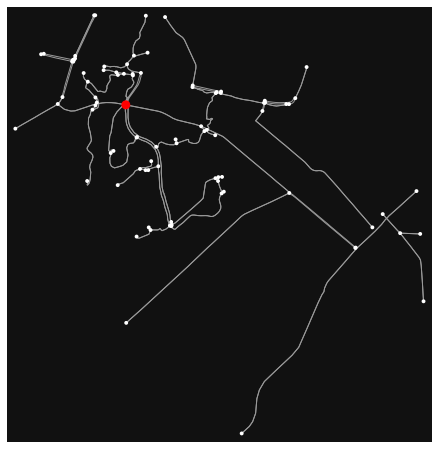

In [22]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

c:\Users\psle1\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\Users\psle1\anaconda3\lib\site-packages\osmnx\plot.py:680: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scalar_mapper = cm.ScalarMappable(normalizer, cm.get_cmap(cmap))


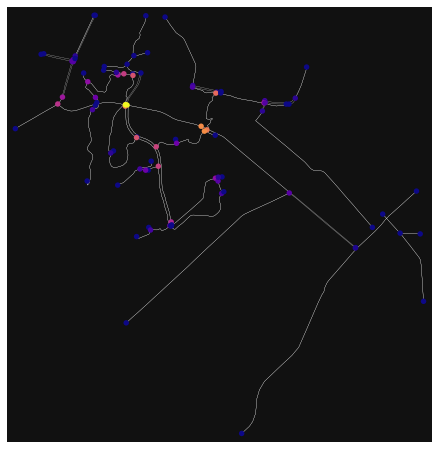

In [23]:

# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)
